# Project Mask Detection

With COVID-19 spreading rapidly, thousands of people are dying each day as there is no effective treatment methods till today and the best form of protection is mask wearing and social distancing. While there are a lot of images online with people wearing mask, annotating a large number of these images is a huge challenge especially a photo with multiple people wearing mask.

Given that there are multiple YoloV5 models available, I attempted to train on increasingly complex models to verify if there is indeed improve in performance. The models used are as follow:
1. YoloV5s without pretrained weights
2. YoloV5s with pretrained weights
3. YoloV5m with pretrained weights

Notebook Sharing Link: https://colab.research.google.com/drive/1X3mcEoepzZ_-I09HvDbHpYwsFYIRrbeC?usp=sharing

In [ ]:
!nvidia-smi

Fri Sep 24 03:44:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Navigate to Directory
%cd /content/drive/MyDrive/Colab Notebooks/masks

/content/drive/MyDrive/Colab Notebooks/masks


# Clone YoloV5 Repo

In [ ]:
# Git clone repository
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9152, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9152 (delta 1), reused 2 (delta 0), pack-reused 9143
Receiving objects: 100% (9152/9152), 9.76 MiB | 3.08 MiB/s, done.
Resolving deltas: 100% (6346/6346), done.


In [ ]:
# Install necessary libraries
!pip install -U -r yolov5/requirements.txt

     |████████████████████████████████| 10.3 MB 11.3 MB/s 
     |████████████████████████████████| 15.7 MB 200 kB/s 
     |████████████████████████████████| 49.9 MB 18 kB/s 
     |████████████████████████████████| 3.0 MB 60.8 MB/s 
     |████████████████████████████████| 636 kB 49.0 MB/s 
     |████████████████████████████████| 28.5 MB 52 kB/s 
     |████████████████████████████████| 831.4 MB 7.7 kB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
     |████████████████████████████████| 76 kB 4.0 MB/s 
     |████████████████████████████████| 11.3 MB 59.4 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
 

# Data Preparation

## Data Augmentation

Data augmentation was done to:
1. Improve model's predictability
2. Increase number of images

Types of data augmentation done:
1. Shearing
2. Noise addition
3. Rotation

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define function to plot
def plot_training_image(img_path, image_type):

    # Basic image description
    print("Image to Detect: Mask")
    print(f"Image type: {image_type}")

    # Read image
    img = mpimg.imread(f'{img_path}')

    # Image shape
    height, width, channels = img.shape
    print(f"Image has the following dimensions: \n Height:{height} \n Width: {width}, \n Channels:{channels}")
    print()

    return img, height, width, channels


### Original Image

Image to Detect: Mask
Image type: Original Image from Internet
Image has the following dimensions: 
 Height:416 
 Width: 416, 
 Channels:3



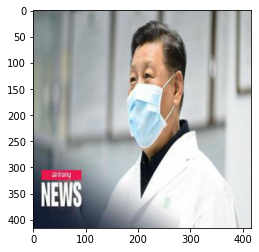

In [ ]:
filepath = "valid/images/naver_0793_jpg.rf.16715f418ec85d67ac5f53d02b3ed74c.jpg"
org_img, height, width, channels = plot_training_image(filepath, "Original Image from Internet")
plt.imshow(org_img) 

### Image Shearing

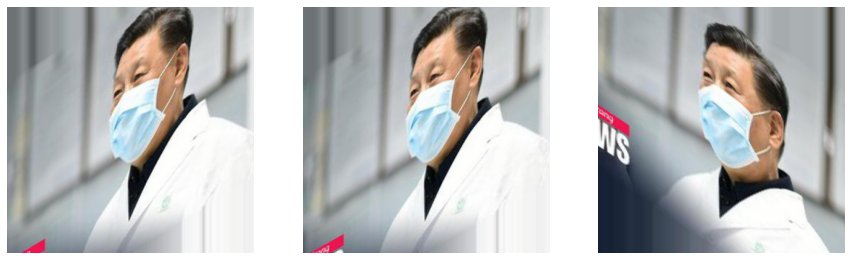

In [ ]:
# ImageDataGenerator shear
datagen = ImageDataGenerator(shear_range=45, fill_mode='nearest')

# iterator
reshaped_img = org_img.reshape(1,416,416,3)
aug_iter = datagen.flow(reshaped_img, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

### Image Rotation

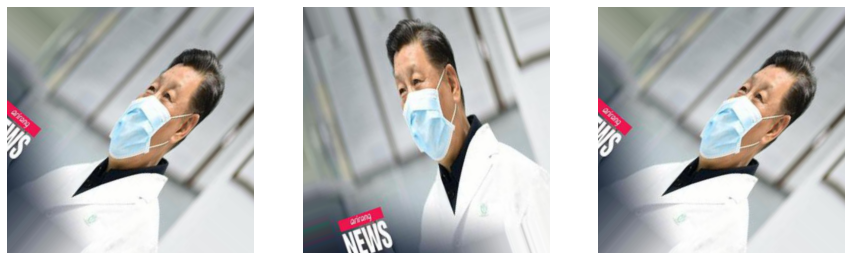

In [ ]:
# ImageDataGenerator rotation
datagen = ImageDataGenerator(rotation_range=45, fill_mode='nearest')

# iterator
reshaped_img = org_img.reshape(1,416,416,3)
aug_iter = datagen.flow(reshaped_img, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

### Image Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


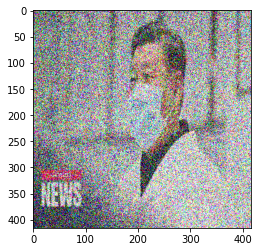

In [ ]:
# Adding Gaussian noise to image
common_type = tf.float32 # Make noise and image of the same type
gnoise = tf.random.normal(shape=tf.shape(org_img), mean=0.0, stddev=0.6, dtype=common_type)
image_type_converted = tf.image.convert_image_dtype(org_img, dtype=common_type, saturate=False)

noisy_image = tf.add(image_type_converted, gnoise)
plt.imshow(noisy_image)

## Define number of classes in yaml file

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
# Check data file
%cat data.yaml

train: train/images
val: valid/images

nc: 1
names: ['mask']

# Model Preparation

In [ ]:
%cat yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  1# number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train YoloV5s Model

Model is trained from scratch and using the smallest YoloV5 model - yolov5s without any pretrained weights.

In [ ]:
!python yolov5/train.py --img 416 --batch 32 --epochs 250 --data 'data.yaml' --cfg yolov5/models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

train: weights=, cfg=yolov5/models/custom_yolov5s.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=250, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2021-9-23 torch 1.9.1+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, 

# Train YoloV5s Model

Training model with pre-trained weights.

In [ ]:
!python yolov5/train.py --img 416 --batch 32 --epochs 250 --data 'data.yaml' --cfg yolov5/models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache

train: weights=yolov5s.pt, cfg=yolov5/models/custom_yolov5s.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=250, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2021-9-23 torch 1.9.1+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv

# Test YoloV5s Model with Pretrained Weights

Run inference on validation images to check results

In [ ]:
!python yolov5/detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.5 --source test_images

detect: weights=['runs/train/yolov5s_results2/weights/best.pt'], source=test_images, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 2021-9-23 torch 1.9.1+cu102 CPU

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
image 1/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/a.jpg: 288x416 1 mask, Done. (0.190s)
image 2/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/b.jpg: 288x416 2 masks, Done. (0.181s)
image 3/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/c.jpg: 288x416 1 mask, Done. (0.202s)
image 4/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/d.jpg: 288x416 4 masks, Done. (0.199s)
image 5/5 /c

# Visualize Yolov5s Results

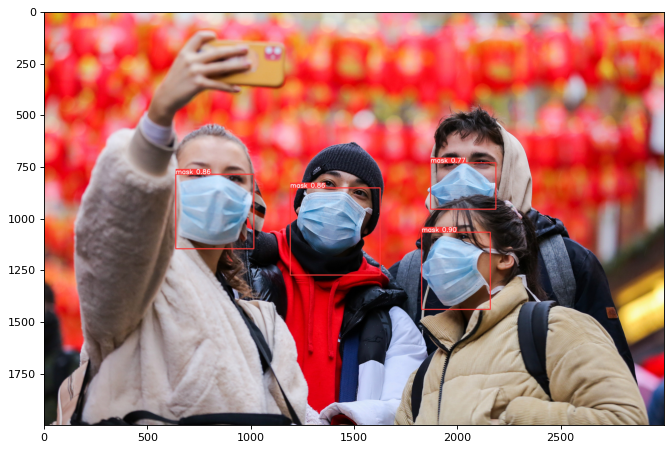

In [ ]:
import random
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)

all_files = os.listdir("runs/detect/exp")

rand_2_files_idx = [random.randint(0,len(all_files)-1) for i in range(2)]

img = mpimg.imread(f'runs/detect/exp/{all_files[rand_2_files_idx[0]]}')
plt.imshow(img)

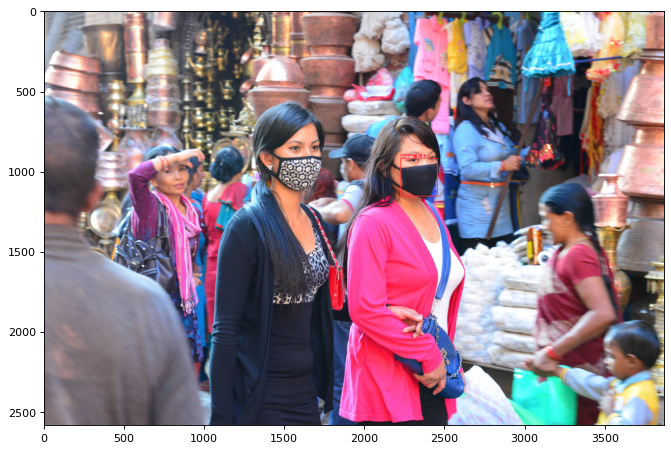

In [ ]:
figure(figsize=(10, 10), dpi=80)
img = mpimg.imread(f'runs/detect/exp/{all_files[rand_2_files_idx[1]]}')
plt.imshow(img)

## Comments on YoloV5s Results

The model did well in identifying regular masks without patterns, for masks with patterns, the model is unable to identify it as a mask.

# Check GPU

In [ ]:
!nvidia-smi

Thu Sep 23 05:39:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Train YoloV5m Model

## Model Preparation

In [ ]:
%%writetemplate yolov5/models/custom_yolov5m.yaml

# Parameters
nc: 1  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


In [ ]:
!python yolov5/train.py --img 416 --batch 32 --epochs 250 --data 'data.yaml' --cfg yolov5/models/custom_yolov5m.yaml --weights yolov5m.pt --name yolov5m_results  --cache

train: weights=yolov5m.pt, cfg=yolov5/models/custom_yolov5m.yaml, data=data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=250, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=yolov5m_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2021-9-23 torch 1.9.1+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv

# Test Yolov5m model

In [ ]:
!python yolov5/detect.py --weights best_y5_230921.pt --img 416 --conf 0.5 --source test_images

detect: weights=['best_y5_230921.pt'], source=test_images, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 2021-9-23 torch 1.9.1+cu102 CPU

Fusing layers... 
Model Summary: 308 layers, 21037638 parameters, 0 gradients, 50.3 GFLOPs
image 1/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/a.jpg: 288x416 1 mask, Done. (0.456s)
image 2/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/b.jpg: 288x416 2 masks, Done. (0.442s)
image 3/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/c.jpg: 288x416 2 masks, Done. (0.431s)
image 4/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/d.jpg: 288x416 4 masks, Done. (0.438s)
image 5/5 /content/drive/My Drive/Co

# Visualize Results

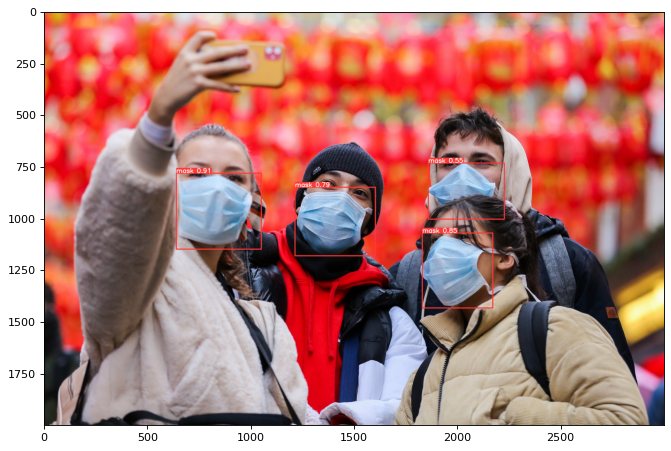

In [ ]:
figure(figsize=(10, 10), dpi=80)
img = mpimg.imread(f'runs/detect/exp2/{all_files[rand_2_files_idx[0]]}')
plt.imshow(img)

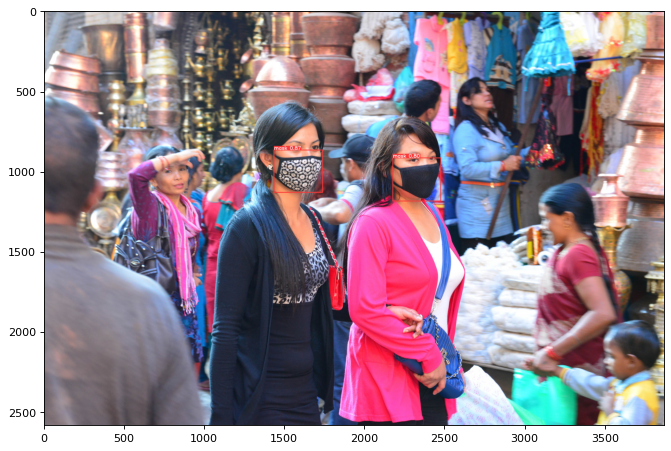

In [ ]:
figure(figsize=(10, 10), dpi=80)
img = mpimg.imread(f'runs/detect/exp2/{all_files[rand_2_files_idx[1]]}')
plt.imshow(img)

## Comments on YoloV5m Results

The model is able to identify **both** regular masks and masks with pattern well with relatively high confidence.

# Test ensemble model

In [ ]:
!python yolov5/detect.py --weights best_y5_230921.pt runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.5 --source test_images

detect: weights=['best_y5_230921.pt', 'runs/train/yolov5s_results2/weights/best.pt'], source=test_images, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 2021-9-23 torch 1.9.1+cu102 CPU

Fusing layers... 
Model Summary: 308 layers, 21037638 parameters, 0 gradients, 50.3 GFLOPs
Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
Ensemble created with ['best_y5_230921.pt', 'runs/train/yolov5s_results2/weights/best.pt']

image 1/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/a.jpg: 288x416 1 mask, Done. (0.689s)
image 2/5 /content/drive/My Drive/Colab Notebooks/masks/test_images/b.jpg: 288x416 2 masks, Done. (0.633s)
image 3/5 /content/dr

# Visualize Results

Model results for Ensemble Model


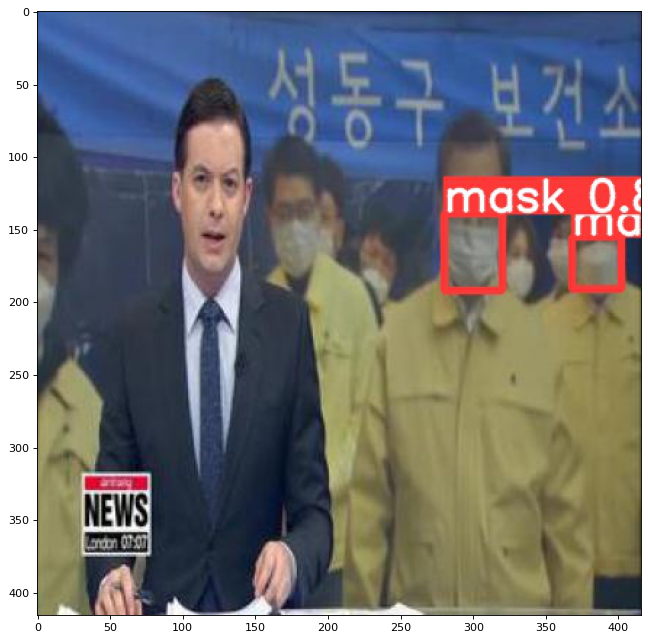

In [ ]:
print("Model results for Ensemble Model")
figure(figsize=(10, 10), dpi=80)
img = mpimg.imread(f'runs/detect/exp3/{all_files[4]}')
plt.imshow(img)

# Conclusion

As seen from the different results produced by the different models, each model has its strength. For YoloV5s, it failed to identify masks with patterns while YoloV5m failed to identify masks when the image is blur and fairly crowded. However, with an ensemble model, I was able to create a model that leverages on the prediction ability of both models and produce results that is much better than any individual model.

With an ensemble model, it was able to identify both masks with pattern as well as masks in a crowded blurred image and thus, is a better model.

Model results for YoloV5s Model


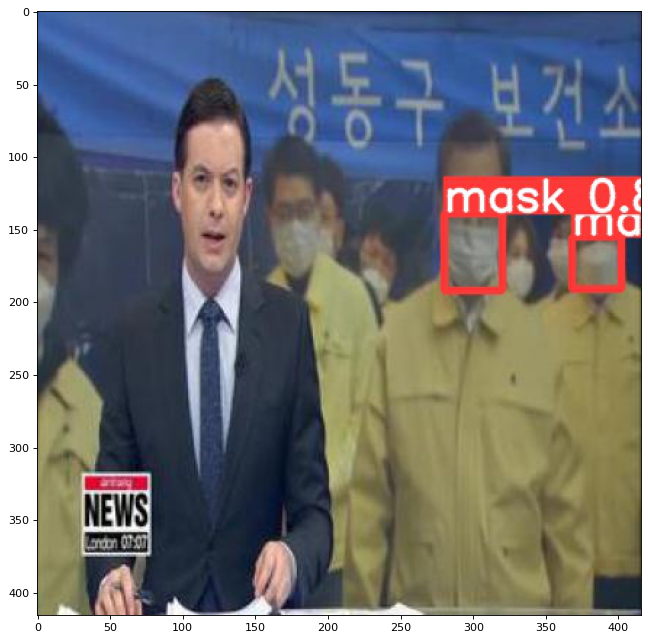

In [ ]:
print("Model results for YoloV5s Model")
figure(figsize=(10, 10), dpi=80)
img = mpimg.imread(f'runs/detect/exp/{all_files[4]}')
plt.imshow(img)

Model results for YoloV5m Model


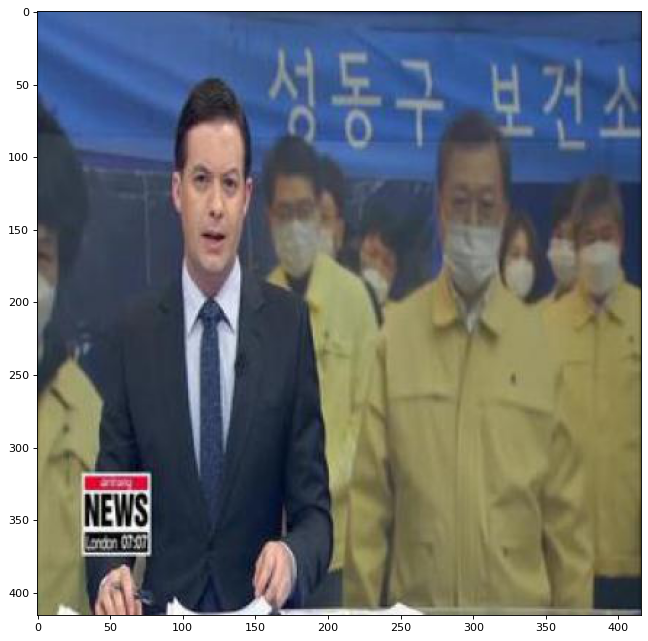

In [ ]:
print("Model results for YoloV5m Model")
figure(figsize=(10, 10), dpi=80)
img = mpimg.imread(f'runs/detect/exp2/{all_files[4]}')
plt.imshow(img)